# Data Preparation

We have data from two PhysioNet databases: MIT-BIH Arrhythmia Database and MIT-BIH Normal Sinus Rhythm Database.

The goal is to make a HRV dataset with the 2 classes equally represented.

In [2]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def count_unique_records(base_folder):
    unique_records = set()

    for folder_name in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder_name)
        record_per_file = 0
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if file_name.endswith('.atr'):
                    record_name = file_name.split('.atr')[0]
                    unique_records.add(record_name)
                    record_per_file+=1

        print(f'There are {record_per_file} records in the folder {folder_name}.')
    return len(unique_records)

# Path to your data folder
data_folder = 'data'

# Count the unique records
num_records = count_unique_records(data_folder)
print(f'Total number of unique records: {num_records}')


Total number of unique records: 0


In [ ]:
def calculate_hrv_signals(base_folder):
    hrv_signals = []
    for folder_name in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder_name)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.atr'):
                record_name = file_name.split('.atr')[0]
                record_path = os.path.join(folder_path, record_name)

                try:
                    # Read annotations
                    ann = wfdb.rdann(record_path, extension='atr')

                    # Extract RR intervals (in seconds)
                    rr_intervals = np.diff(ann.sample / ann.fs)[5:-5]

                    # Calculate HRV features
                    sdnn = np.std(rr_intervals)  # Standard deviation of RR intervals (SDNN)
                    rmssd = np.sqrt(np.mean(np.diff(rr_intervals)**2))  # Root mean square of successive differences (RMSSD)
                    mean = np.mean(rr_intervals)
                    # Store HRV features in a dictionary or structure
                    hrv_signals.append({
                        'folder_name': folder_name[:10],
                        'record_name': record_name,
                        'SDNN': sdnn,
                        'RMSSD': rmssd,
                        'MEAN': mean,
                        'length': len(rr_intervals),
                        'RR_intervals': rr_intervals.tolist()  # Convert to list for easier storage if needed
                    })

                except Exception as e:
                    print(f"Error processing {record_path}: {e}")

    return hrv_signals

# Example usage
data_folder = 'data'
hrv_signals = calculate_hrv_signals(data_folder)

# Print or process the calculated HRV signals
for signal in hrv_signals:
    print(f"Folder: {signal['folder_name']}, Record: {signal['record_name']}, SDNN: {signal['SDNN']:.4f}, RMSSD: {signal['RMSSD']:.4f}, mean: {signal['MEAN']:.4f} length: {signal['length']}")


Error processing data\mit-bih-arrhythmia-database-1.0.0\102-0: unsupported operand type(s) for /: 'int' and 'NoneType'
Folder: mit-bih-ar, Record: 100, SDNN: 0.0487, RMSSD: 0.0633, mean: 0.7948 length: 2263
Folder: mit-bih-ar, Record: 101, SDNN: 0.0839, RMSSD: 0.0700, mean: 0.9640 length: 1863
Folder: mit-bih-ar, Record: 102, SDNN: 0.0409, RMSSD: 0.0469, mean: 0.8241 length: 2181
Folder: mit-bih-ar, Record: 103, SDNN: 0.0590, RMSSD: 0.0471, mean: 0.8637 length: 2080
Folder: mit-bih-ar, Record: 104, SDNN: 0.1156, RMSSD: 0.1243, mean: 0.7817 length: 2300
Folder: mit-bih-ar, Record: 105, SDNN: 0.1239, RMSSD: 0.1539, mean: 0.6709 length: 2680
Folder: mit-bih-ar, Record: 106, SDNN: 0.2762, RMSSD: 0.4328, mean: 0.8609 length: 2087
Folder: mit-bih-ar, Record: 107, SDNN: 0.0446, RMSSD: 0.0540, mean: 0.8442 length: 2129
Folder: mit-bih-ar, Record: 108, SDNN: 0.1817, RMSSD: 0.2016, mean: 0.9908 length: 1813
Folder: mit-bih-ar, Record: 109, SDNN: 0.0404, RMSSD: 0.0467, mean: 0.7126 length: 2524
F

In [5]:
import os
import wfdb
import numpy as np

def reshape_to_batches(array, m):
    """
    Transform an array of shape (n,) into a list of arrays of shape (m,).
    """
    array = np.asarray(array)
    n = array.shape[0]
    num_batches = n // m
    return [array[i * m:(i + 1) * m] for i in range(num_batches)]

def calculate_hrv_signals(base_folder, batch_size=100):
    hrv_batches = []
    label = -1
    y = []
    for folder_name in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder_name)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.atr'):
                record_name = file_name.split('.atr')[0]
                record_path = os.path.join(folder_path, record_name)

                try:
                    # Read annotations
                    ann = wfdb.rdann(record_path, extension='atr')

                    # Extract RR intervals (in seconds)
                    rr_intervals = np.diff(ann.sample / ann.fs)[10:-10]

                    # Batch the RR intervals
                    rr_batches = reshape_to_batches(rr_intervals, batch_size)

                    # Calculate HRV features for each batch and store them
                    for batch in rr_batches:
                        # sdnn = np.std(batch)
                        # rmssd = np.sqrt(np.mean(np.diff(batch)**2))
                        # mean_rr = np.mean(batch)
                        hrv_batches.append(batch)
                        y.append(label)

                except Exception as e:
                    print(f"Error processing {record_path}: {e}")
        label += 1
    # Convert the list of HRV features to a numpy array
    hrv_batches_array = np.array(hrv_batches)

    return hrv_batches_array, np.array(y)

# Example usage
data_folder = 'data'
hrv_signals_array,y = calculate_hrv_signals(data_folder, batch_size=1_000)

# Print the shape of the concatenated HRV features array
print(f"Shape of HRV signals array: {hrv_signals_array.shape}")

# Print the first few HRV feature sets
print(hrv_signals_array.shape)


FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'data'

In [ ]:
np.unique(y,return_counts=True)

(array([0, 1]), array([ 1092, 18055], dtype=int64))

In [ ]:
np.save('hrv_signals2', hrv_signals_array)
np.save('hrv_labels2',y)

In [ ]:
np.where(y)

(array([ 1092,  1093,  1094, ..., 19144, 19145, 19146], dtype=int64),)

In [ ]:
import numpy as np

def get_hrv_dataset(n_samples):
    """
    Create a dataset of HRV signals with balanced classes.

    Parameters:
    hrv_signals_path (str): Path to the numpy file containing HRV signals.
    hrv_labels_path (str): Path to the numpy file containing HRV labels.
    n_samples (int): Number of samples to include in the dataset.

    Returns:
    tuple: A tuple containing the HRV dataset and corresponding labels.
    """
    # Load HRV signals and labels
    hrv_signals = np.load('hrv_signals.npy')
    hrv_labels = np.load('hrv_labels.npy')

    # Get indices for the two classes
    class_1_indices = np.where(hrv_labels == 1)[0]
    class_0_indices = np.where(hrv_labels == 0)[0]

    # Shuffle the indices
    np.random.shuffle(class_1_indices)
    np.random.shuffle(class_0_indices)

    # Select n_samples/2 samples from each class
    selected_class_1_indices = class_1_indices[:n_samples//2]
    selected_class_0_indices = class_0_indices[:n_samples//2]

    # Get the corresponding HRV signals
    X1 = hrv_signals[selected_class_1_indices]
    X0 = hrv_signals[selected_class_0_indices]

    # Create the dataset and labels
    X = np.concatenate([X0, X1])
    y = np.concatenate([np.zeros(n_samples//2), np.ones(n_samples//2)])

    return X, y

# Example usage
hrv_signals_path = 'hrv_signals.npy'
hrv_labels_path = 'hrv_labels.npy'
n_samples = 100

X, y = get_hrv_dataset(n_samples)

# Print shapes of the dataset and labels to verify
print(f"Shape of HRV dataset: {X.shape}")
print(f"Shape of HRV labels: {y.shape}")


Shape of HRV dataset: (100, 100)
Shape of HRV labels: (100,)


In [ ]:
get_hrv_dataset(50)

(array([[0.63888889, 0.66111111, 0.69166667, ..., 0.65277778, 0.63888889,
         0.59722222],
        [0.95555556, 0.88611111, 0.99444444, ..., 0.92777778, 0.94444444,
         0.975     ],
        [0.69444444, 0.725     , 0.69444444, ..., 0.76666667, 0.78611111,
         0.80555556],
        ...,
        [0.7734375 , 0.7890625 , 0.7890625 , ..., 0.71875   , 0.75      ,
         0.7734375 ],
        [0.7109375 , 0.7109375 , 0.703125  , ..., 1.0078125 , 0.90625   ,
         0.9453125 ],
        [0.8359375 , 0.8359375 , 0.8203125 , ..., 0.9765625 , 0.96875   ,
         0.9921875 ]]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [ ]:
stop

NameError: name 'stop' is not defined

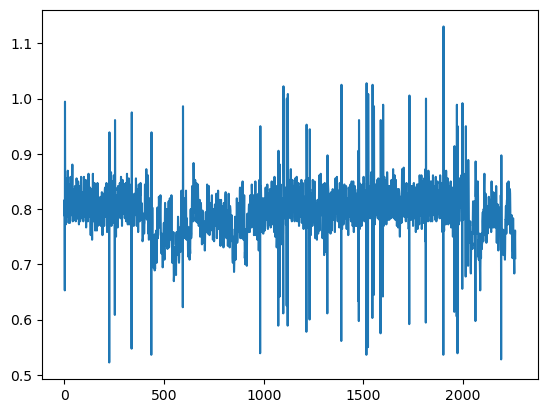

In [ ]:
plt.plot(hrv_signals[0]['RR_intervals'])

In [ ]:
y1,y2 =list(), list()
std1,std2 = list(), list()
for signal in hrv_signals:
    if signal['folder_name'] == 'mit-bih-ar':
        y1.append(signal['MEAN'])
        std1.append(signal['SDNN'])
    
    if signal['folder_name'] == 'mit-bih-no':
        y2.append(signal['MEAN'])
        std2.append(signal['SDNN'])

(-0.2, 2.0)

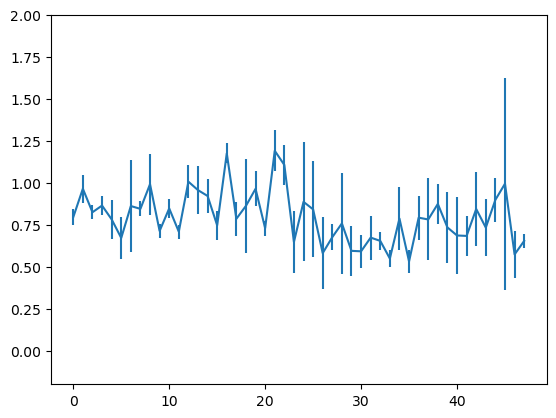

In [ ]:
plt.errorbar(x = range(len(y1)),y=y1,yerr=std1)
plt.ylim(-0.2,2)


(-0.2, 2.0)

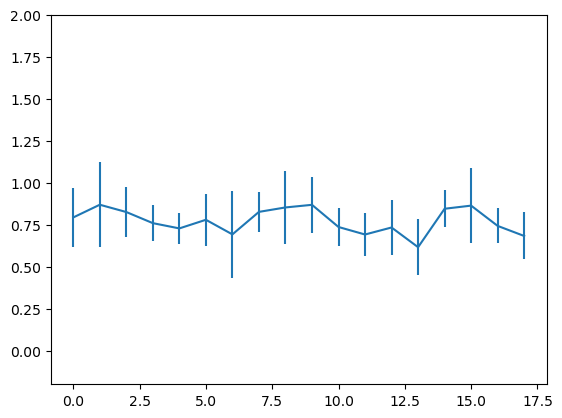

In [ ]:
plt.errorbar(x = range(len(y2)),y=y2,yerr=std2)
plt.ylim(-0.2,2)

(-0.2, 2.0)

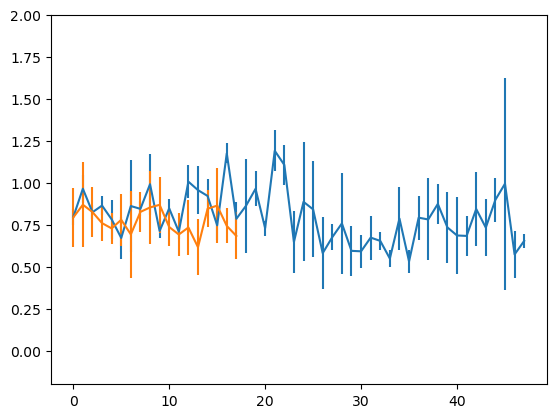

In [ ]:
plt.errorbar(x = range(len(y1)),y=y1,yerr=std1)
plt.errorbar(x = range(len(y2)),y=y2,yerr=std2)
plt.ylim(-0.2,2)

### Outliers

In [ ]:
record_path = "data/mit-bih-normal-sinus-rhythm-database-1.0.0/18177"
record_path2 = "data/mit-bih-arrhythmia-database-1.0.0/232"
ann = wfdb.rdann(record_path2, extension='atr')

In [ ]:
# Extract RR intervals (in seconds)
rr_intervals = np.diff(ann.sample / ann.fs)[1:]

# Calculate HRV features
sdnn = np.std(rr_intervals)  # Standard deviation of RR intervals (SDNN)
rmssd = np.sqrt(np.mean(np.diff(rr_intervals)**2))  # Root mean square of successive differences (RMSSD)


In [ ]:
rr_intervals[-10:-1]

array([0.74444444, 0.76388889, 1.78055556, 0.69722222, 0.75      ,
       0.76388889, 0.75833333, 1.71388889, 0.7       ])

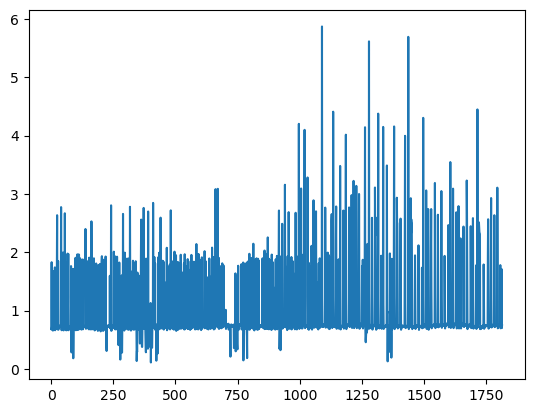

In [ ]:
plt.plot(rr_intervals)

In [ ]:
# 'mit-bih-ar' == folder

NameError: name 'folder' is not defined

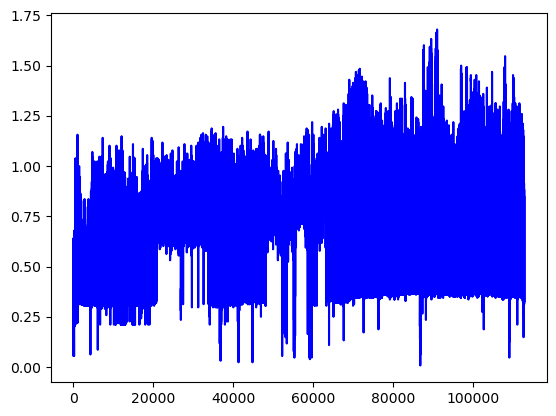

In [ ]:
rand_int = np.random.randint(len(hrv_signals))
folder = hrv_signals[rand_int]['folder_name']

color = 'r' if ('mit-bih-ar' == folder) else 'b'

plt.plot(hrv_signals[rand_int]['RR_intervals'], color=color)

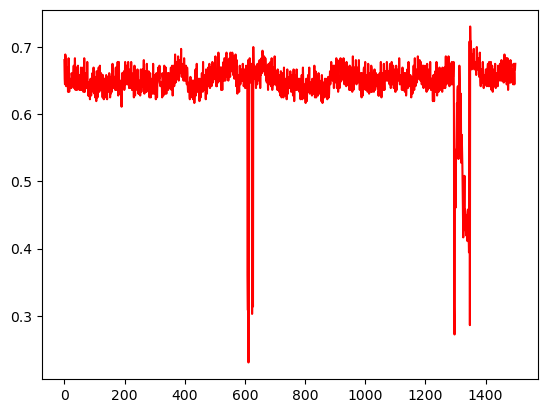

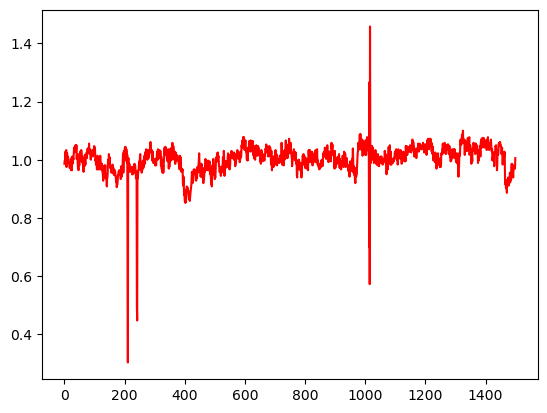

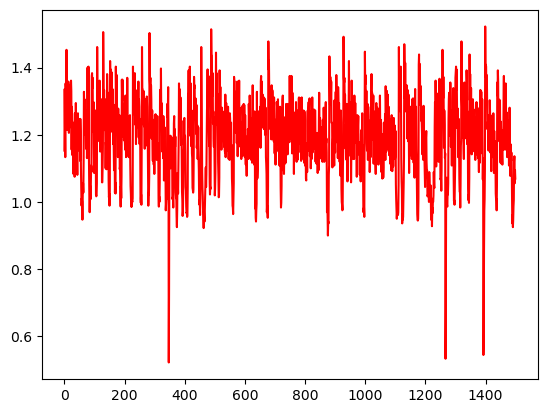

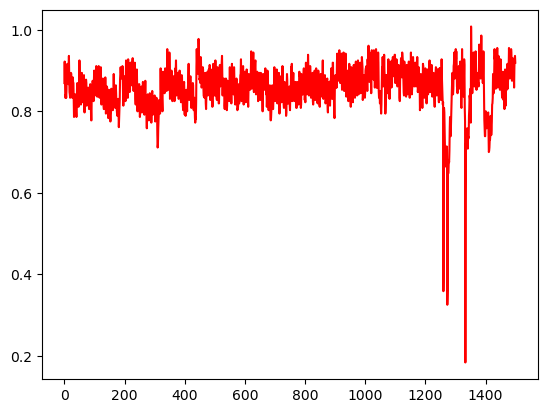

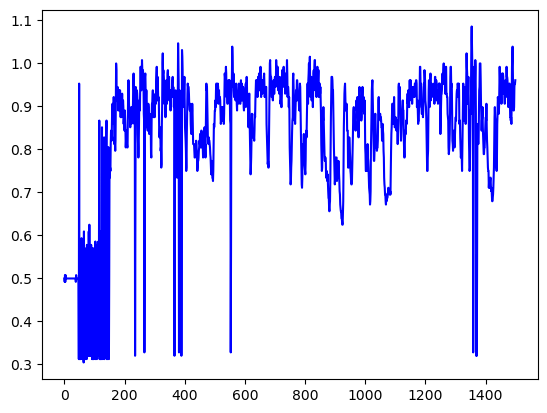

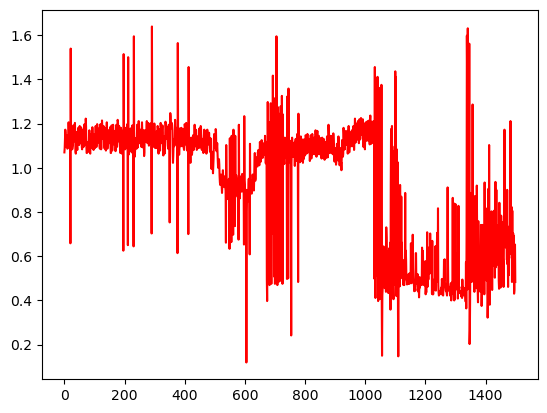

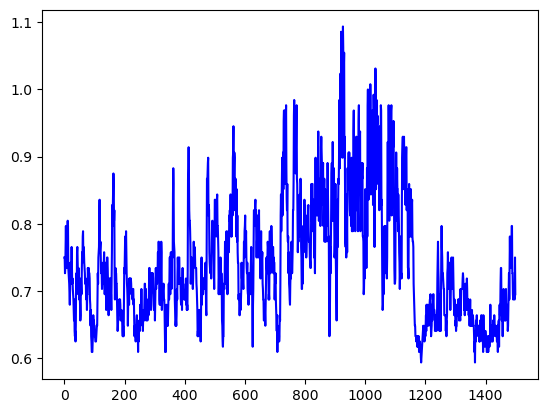

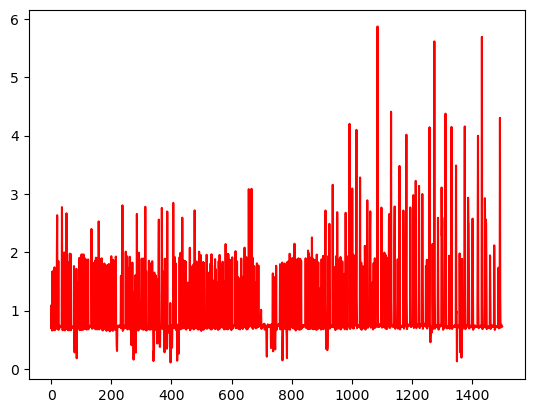

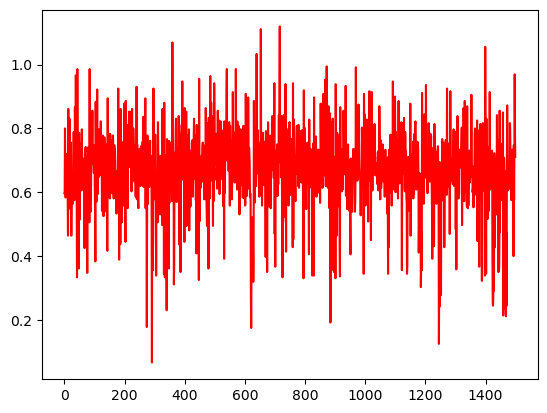

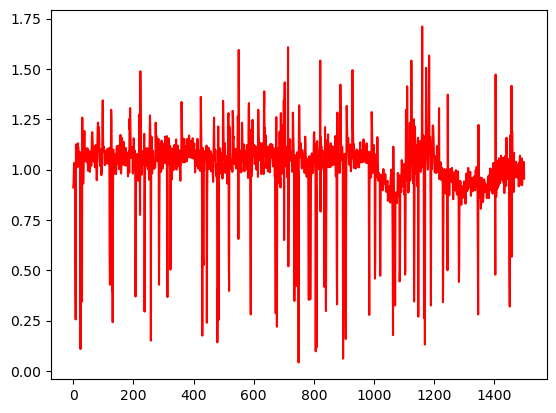

In [ ]:
for _ in range(10):
    rand_int = np.random.randint(len(hrv_signals))
    folder = hrv_signals[rand_int]['folder_name']

    color = 'r' if ('mit-bih-ar' == folder) else 'b'

    plt.plot(hrv_signals[rand_int]['RR_intervals'][:1500], color=color)
    plt.title(hrv_signals[rand_int]["record_name"])
    plt.show()

## Data Prep

In [ ]:
hrv_signals

[{'folder_name': 'mit-bih-ar',
  'record_name': '100',
  'SDNN': 0.04871882058238163,
  'RMSSD': 0.06334867955052004,
  'MEAN': 0.7947930475769627,
  'length': 2263,
  'RR_intervals': [0.7888888888888888,
   0.8166666666666673,
   0.6527777777777777,
   0.9944444444444445,
   0.8444444444444441,
   0.8111111111111109,
   0.7888888888888896,
   0.7722222222222221,
   0.8388888888888886,
   0.8555555555555561,
   0.8222222222222211,
   0.8277777777777775,
   0.8222222222222229,
   0.7944444444444443,
   0.7972222222222225,
   0.7916666666666679,
   0.8222222222222229,
   0.8694444444444436,
   0.8222222222222229,
   0.7861111111111079,
   0.7916666666666679,
   0.7750000000000021,
   0.7861111111111079,
   0.8111111111111136,
   0.8166666666666664,
   0.8277777777777757,
   0.844444444444445,
   0.8055555555555571,
   0.7749999999999986,
   0.8000000000000007,
   0.7888888888888879,
   0.8583333333333343,
   0.8416666666666686,
   0.8249999999999993,
   0.8027777777777771,
   0.836111111